In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import h5py
import os

from PIL import Image



# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-05-01 17:59:03.629601: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 17:59:03.662767: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 17:59:03.662798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 17:59:03.664002: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 17:59:03.670081: I tensorflow/core/platform/cpu_feature_guar

In [2]:
with h5py.File('TrainingData5zeroes midpoints.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    center_coordinates = hdf.get('center_coordinates')
    images = np.array(images)
    boxes = np.array(boxes)
    center_coordinates = np.array(center_coordinates)

image_normalized = (images + 1e-9) / 9.26
# normalized_boxes = boxes / [1, 64, 64, 64, 64]

images_np = image_normalized
center_coordinates = center_coordinates / [1,64, 64]  # Normalizing the center coordinates
probabilities = np.array(center_coordinates[:,:, :-2])
probabilities = tf.expand_dims(probabilities, axis=1)
center_coordinates_np = np.array(center_coordinates[:, :, 1:])
center_coordinates_np = tf.expand_dims(center_coordinates_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
# dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)
total_items = len(images_np)
train_size = int(total_items * 0.6)
test_size = total_items - train_size 

    # Splitting the dataset
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)


train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size) 

2024-05-01 17:59:08.238157: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22081 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [69]:
center_coordinates_np[3]

<tf.Tensor: shape=(1, 280, 2), dtype=float64, numpy=
array([[[0.609375 , 0.3828125],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       ,

In [70]:
probabilities.shape, center_coordinates_np.shape

(TensorShape([10000, 1, 280, 1]), TensorShape([10000, 1, 280, 2]))

In [58]:
input_shape = (64,64,1)
num_classes = 280
num_coordinates = 2

x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
#Layer 5
x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 


x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_midpoints = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_midpoints')(x)
x_midpoints_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_midpoints_reshape')(x_midpoints)




loadedmodel = tf.keras.models.Model(x_input, [x_prob_reshape, x_midpoints_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
loadedmodel.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_midpoints_reshape':tf.keras.losses.MeanSquaredError()}, metrics=['accuracy'])    
num_epochs = 2500

In [59]:
loadedmodel = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/midpoint2.keras")
# loadmodel = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/Sweep Weights/Train and Val/northern-sweep-1.h5")

In [60]:
loadedmodel.fit(train_dataset, epochs=num_epochs)

Epoch 1/2500


2024-05-01 21:15:04.451383: W tensorflow/core/kernels/gpu_utils.cc:54] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-05-01 21:15:05.527191: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.95GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-01 21:15:16.275156: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.93GiB (rounded to 3145728000)requested by op model_4/conv2d_43/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation su

ResourceExhaustedError: Graph execution error:

Detected at node model_4/conv2d_43/Relu defined at (most recent call last):
  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/m3-learning/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1077, in launch_instance

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/m3-learning/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/m3-learning/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/m3-learning/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_257997/624469361.py", line 1, in <module>

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/activations.py", line 306, in relu

  File "/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/backend.py", line 5395, in relu

OOM when allocating tensor with shape[6000,128,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_4/conv2d_43/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_895489]

In [54]:
# loadmodel.save("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/midpoint2.keras")

In [7]:

dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_midpoints_reshape': center_coordinates_np}))
# dataset = dataset.batch(1000)
# test_dataset = dataset.skip(train_size)
# # test_dataset = test_dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
# test_dataset = test_dataset.batch(test_size)
train_dataset = dataset.take(train_size)
# train_dataset = train_dataset.shuffle(buffer_size=10000,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(train_size)
inputs,targets = next(iter(train_dataset))
output =loadmodel.predict(inputs)

188/188 [==============================] - 2s 8ms/step


In [19]:
output[1][4]

array([[[5.67162752e-01, 4.19786215e-01],
        [3.71047594e-02, 3.41538265e-02],
        [2.53582783e-02, 1.43528804e-02],
        [9.31250211e-03, 4.82149888e-03],
        [4.24607890e-03, 3.75412405e-03],
        [9.75070230e-04, 1.90074719e-03],
        [6.69547007e-04, 3.00857471e-04],
        [5.31193393e-04, 2.66211515e-04],
        [7.57174494e-05, 1.31512337e-04],
        [1.44571910e-04, 5.90433410e-05],
        [1.58776034e-04, 1.21425001e-04],
        [1.89387385e-04, 9.84017388e-05],
        [1.56983544e-04, 3.10251635e-05],
        [3.13171244e-04, 5.56248706e-04],
        [4.23685153e-04, 3.72429378e-04],
        [2.27216166e-04, 3.15795885e-04],
        [8.57930921e-04, 2.46377254e-04],
        [1.16479678e-04, 7.04354607e-04],
        [6.57207856e-04, 2.40290014e-04],
        [7.09167740e-04, 6.19033934e-04],
        [6.48423040e-04, 2.92129116e-04],
        [1.36845454e-03, 1.04866957e-03],
        [1.64348143e-03, 1.35839335e-03],
        [2.81267421e-04, 1.0075043

In [20]:
 
targets['x_midpoints_reshape'][4]

<tf.Tensor: shape=(1, 280, 2), dtype=float64, numpy=
array([[[0.5546875, 0.4375   ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       , 0.       ],
        [0.       ,

Conversion From Regression to Classification

In [9]:
# import numpy as np
# import tensorflow as tf

# # Assuming you have loaded the model and the dataset
# dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_boxes_reshape': boxes_np}))
# dataset = dataset.batch(301)  # Adjust the batch size according to your needs
# inputs, targets = next(iter(dataset))

# # Predict using the loaded model
# output = loadmodel.predict(inputs)

# # Define thresholds
# # prediction_thresholds = np.array([0.4] * output[1].shape[1])  # Adjust this according to your output dimensions and scale
# # difference_thresholds = np.array([0.1] * output[1].shape[1])  # Adjust this according to what you consider a close enough prediction
# prediction_thresholds = np.array([0.5, 0.5, 0.5, 0.5])
# difference_thresholds = np.array([0.1, 0.1, 0.1, 0.1])

# # # Evaluate predictions function (as previously defined)
# # def evaluate_predictions(y_true, y_pred, pred_thresh, diff_thresh):
# #     predicted_classes = (y_pred > pred_thresh).astype(int)
# #     abs_diff = np.abs(y_pred - y_true)
# #     is_close_enough = abs_diff <= diff_thresh

# #     TP = np.logical_and(predicted_classes == 1, is_close_enough)
# #     FP = np.logical_and(predicted_classes == 1, np.logical_not(is_close_enough))
# #     TN = np.logical_and(predicted_classes == 0, is_close_enough)
# #     FN = np.logical_and(predicted_classes == 0, np.logical_not(is_close_enough))

# #     return np.sum(TP), np.sum(FP), np.sum(TN), np.sum(FN)


# import numpy as np

# def evaluate_predictions(y_true, y_pred, pred_thresh, diff_thresh):
#     predicted_classes = (y_pred > pred_thresh).astype(int)
#     abs_diff = np.abs(y_pred - y_true)
#     is_close_enough = abs_diff <= diff_thresh
    
#     # True Positive: All coordinates must be close enough in a positively predicted sample
#     TP = (predicted_classes == 1) & np.all(is_close_enough, axis=1)
    
#     # False Positive: Any coordinate not close enough in a positively predicted sample
#     FP = (predicted_classes == 1) & ~np.all(is_close_enough, axis=1)
    
#     # True Negative: Predicted as negative (no need to check closeness)
#     TN = (predicted_classes == 0)
    
#     # False Negative: Predicted as negative but should have been positive (based on prediction threshold alone)
#     FN = (predicted_classes == 0) & (y_true > pred_thresh).any(axis=1)
    
#     return np.sum(TP), np.sum(FP), np.sum(TN), np.sum(FN)


# # Assuming 'targets' dictionary contains arrays that match keys with 'output' dictionary keys
# total_TP = total_FP = total_TN = total_FN = 0

# TP, FP, TN, FN = evaluate_predictions(targets['x_boxes_reshape'].numpy(), output[1], prediction_thresholds, difference_thresholds)
# total_TP += TP
# total_FP += FP
# total_TN += TN
# total_FN += FN

# # Calculate precision and recall
# precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
# recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0

# # Calculate F1 score
# if (precision + recall) > 0:
#     f1_score = 2 * (precision * recall) / (precision + recall)
# else:
#     f1_score = 0

# print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')


10/10 [==============================] - 0s 8ms/step
Precision: 0.8820072711959346, Recall: 0.5789277967271784, F1 Score: 0.6990297343422884


In [ ]:
# def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.9):
#     """
#     Visualizes bounding boxes on an image based on a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
#     - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
#     - threshold: Probability threshold for visualization.

#     Returns:
#     None (displays the image with bounding boxes).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     prob_vector_np = probability_vector
#     bbox_coordinates_np = bounding_box_coordinates
#    # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title("Bounding Box Visualization")

#     # Plot bounding boxes based on probability threshold
#     for i in range(len(prob_vector_np)):
#         prob = prob_vector_np[i]
#         bbox = bbox_coordinates_np[i]
#         if prob > threshold:
#             # Denormalize bounding box coordinates if necessary
#             denormalized_bbox = bbox  # Modify if normalization was applied during training
#             y1, x1, y2, x2 = denormalized_bbox
#             plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
#                      color='r', linewidth=2, label='Bounding Box')

   






   
#     plt.show()

# t = np.random.randint(0,200)
# # probabilities = tf.convert_to_tensor(output[0][t,:])

# visualize_bounding_boxes(tf.convert_to_tensor(inputs[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64,64,64]) ##myprediction
# visualize_bounding_boxes(tf.convert_to_tensor(image_normalized[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(boxes_np[t,0,:,:])*[64,64,64,64]) ##myprediction


In [46]:
output[1][2].shape

(1, 280, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


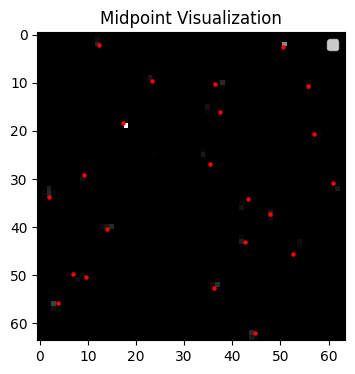

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


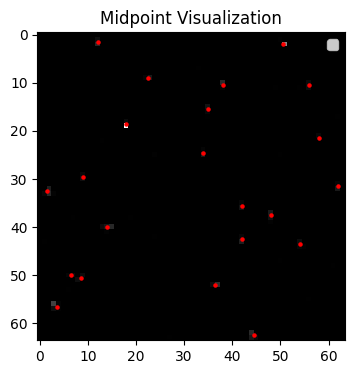

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
    """
    Visualizes midpoints on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
    - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with midpoints).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    midpoints_np = midpoints#.numpy() if hasattr(midpoints, 'numpy') else midpoints

    # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Midpoint Visualization")

    # Plot midpoints based on probability threshold
    for i, (y,x) in enumerate(midpoints_np):
        prob = prob_vector_np[i]
        if prob > threshold:
            plt.scatter(x, y, color='red', s=5)
            if i == 0:  # Add label only once to avoid repetition in the legend
                plt.legend()

    plt.show()

t = np.random.randint(0,2000)

visualize_midpoints(tf.convert_to_tensor(inputs[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64]) ##myprediction      
visualize_midpoints(tf.convert_to_tensor(images_np[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64]) ##myprediction           

# import numpy as np
# import matplotlib.pyplot as plt

# def visualize_midpoints(image, probability_vector, midpoints, threshold=0.8):
#     """
#     Visualizes midpoints on an image based on a probability vector, ensuring coordinates match image plotting conventions.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - probability_vector: A 1D tensor representing the probabilities associated with midpoints.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
#     - threshold: Probability threshold for visualization.

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image.numpy() if hasattr(image, 'numpy') else image
#     prob_vector_np = probability_vector.numpy() if hasattr(probability_vector, 'numpy') else probability_vector
#     midpoints_np = midpoints.numpy() if hasattr(midpoints, 'numpy') else midpoints

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(image_np, cmap='gray')
#     plt.title("Midpoint Visualization")

#     # Adjust axes if needed
#     plt.gca().invert_yaxis()  # Invert the y-axis to match image coordinates

#     # Plot midpoints based on probability threshold
#     for i, (y,x) in enumerate(midpoints_np):
#         prob = prob_vector_np[i]
#         if prob > threshold:
#             plt.scatter(x, y, color='red', s=5, label='Midpoint' if i == 0 else "")

#     plt.show()

# # Example usage
# t = 6
# visualize_midpoints(inputs[t], probabilities[t].numpy().squeeze(), output[1][t, 0, :, :] * [64, 64])
# visualize_midpoints(tf.convert_to_tensor(images_np[t]), probabilities[t].numpy().squeeze(), tf.convert_to_tensor(center_coordinates_np[t,0,:,:])*[64,64]) ##myprediction

